A.S. Lundervold, 29.02.2024

***Under construction***

# Introduction

This notebook steps through an example of text classification using fastai's ULMFiT and DistilBERT models via Hugging Face's Transformers library.

> Be sure to also work through [Chapter 10](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb) of the fastai textbook and [Lesson 4](https://course.fast.ai/Lessons/lesson4.html) of the fastai course.

# Setup

In [1]:
%matplotlib inline
from pathlib import Path
import os, sys
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from fastcore.all import *

In [2]:
DATA = Path.home() /'data'/'dat255'
DATA

Path('/home/alex/data/dat255')

# Load data

We can find many datasets on the Hugging Face Hub:

In [3]:
from huggingface_hub import HfApi

In [4]:
api = HfApi()

Here's a list of all the available datasets. There are a lot!

In [6]:
len(list(api.list_datasets()))

112863

Here are the 20 most popular datasets:

In [6]:
list(api.list_datasets(sort="downloads", direction=-1))[:20]

[DatasetInfo(id='argilla/databricks-dolly-15k-curated-en', author='argilla', sha='4dcd1dedbe148307a833c931b21ca456a1fc4281', created_at=datetime.datetime(2023, 5, 30, 8, 54, 44, tzinfo=datetime.timezone.utc), last_modified=datetime.datetime(2023, 10, 2, 11, 32, 53, tzinfo=datetime.timezone.utc), private=False, gated=False, disabled=False, downloads=10271035, likes=30, paperswithcode_id=None, tags=['language:en', 'croissant', 'region:us'], card_data=None, siblings=None),
 DatasetInfo(id='hails/mmlu_no_train', author='hails', sha='7f9d4f237bd7496914f430fa600c73017331885f', created_at=datetime.datetime(2023, 10, 31, 17, 25, 54, tzinfo=datetime.timezone.utc), last_modified=datetime.datetime(2024, 1, 22, 20, 46, 30, tzinfo=datetime.timezone.utc), private=False, gated=False, disabled=False, downloads=6398747, likes=2, paperswithcode_id=None, tags=['task_categories:question-answering', 'language:en', 'license:mit', 'region:us'], card_data=None, siblings=None),
 DatasetInfo(id='cais/mmlu', aut

In this notebook, we'll use the `emotion` dataset sourced from [CARER: Contextualized Affect Representations for Emotion Recognition](https://aclanthology.org/D18-1404) (Saravia et al., EMNLP 2018). This dataset contains 16,000 tweets, each labeled with one of 6 emotions: anger, fear, joy, love, sadness, and surprise.

In [5]:
from datasets import load_dataset
emotion = load_dataset("emotion", cache_dir=DATA)

/home/alex/anaconda3/envs/fastai/lib/python3.11/site-packages/datasets/load.py:1454: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [9]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Here are the first few tweets and their corresponding emotions:

In [10]:
emotion['train'][0:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

For convenience, we'll store the data in a Pandas DataFrame.

In [11]:
# For convenience, we'll store the data in a Pandas DataFrame, adding a "usage" column indicating train, validation, test
df = pd.concat([pd.DataFrame(emotion['train']), pd.DataFrame(emotion['validation']), pd.DataFrame(emotion['test'])])

# Add named labels
idx_to_emotion = dict(enumerate(emotion['train'].features['label'].names))
df['named_label'] = df['label'].map(idx_to_emotion)

# Add "usage" column
df['usage'] = np.array(['train']*len(emotion['train']) + ['valid']*len(emotion['validation']) + ['test']*len(emotion['test']))

In [12]:
pd.set_option('display.max_colwidth', None)

In [13]:
df.head()

,text,label,named_label,usage
0,i didnt feel humiliated,0,sadness,train
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,0,sadness,train
2,im grabbing a minute to post i feel greedy wrong,3,anger,train
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,2,love,train
4,i am feeling grouchy,3,anger,train


In [14]:
df.usage.value_counts()

usage
train    16000
valid     2000
test      2000
Name: count, dtype: int64

The task is to classify each tweet into one of the six emotions.


# Ulmfit using fastai

Remember from fastai that the ULMFiT approach consists of three steps:

0. **LM pretraining**: Train a language model on a large corpus of text.
1. **LM fine-tuning**: Fine-tune the language model on the target dataset.
2. **Classifier training**: Fine-tune a classifier built from the LM on the target dataset.

In our case, we'll skip the LM pretraining and use a model that's been trained on text from Wikipedia (the [Wikitext-103 data set](https://developer.ibm.com/exchanges/data/all/wikitext-103/)). 

Here's an illustration of the approach taken from fastai: 

<img width=80% src="https://docs.fast.ai/images/ulmfit.png"><br><small>Figure from https://docs.fast.ai/tutorial.text.html</small>

In [15]:
from fastai.text.all import *

For convenience when using fastai, we add indicator variables for the training, testing and validation sets. We also separate the training and validation dataframe from the one containing test data (which we'll use for the final evaluation).

In [16]:
df.loc[:, 'is_test'] = df.usage=='test'

In [19]:
df_train = df[(df.usage=='train') | (df.usage=='valid')].copy()
df_test = df[df.usage=='test']

In [20]:
df_train.loc[:, 'is_valid'] = df_train.usage=='valid'

In [21]:
df.is_test.value_counts()

is_test
False    18000
True      2000
Name: count, dtype: int64

In [22]:
df_train.is_valid.value_counts()

is_valid
False    16000
True      2000
Name: count, dtype: int64

## Step 1: Fine-tune the language model

In [23]:
data_lm = TextDataLoaders.from_df(df_train, text_col='text', label_col="named_label", is_lm=True, bs=64, valid_col="is_valid")

In [24]:
data_lm.show_batch(max_n=3)

,text,text_
0,xxbos i hate being in an environment where i m constantly feeling rejected cast aside and forgotten e xxbos i xxunk at peter feeling somehow triumphant when it was only partially forced xxbos i ve been feeling very indecisive lately xxbos i am currently but i can t even do that right now without feeling indecisive and tied to school and writing and assignments xxbos i feel like we have so much,i hate being in an environment where i m constantly feeling rejected cast aside and forgotten e xxbos i xxunk at peter feeling somehow triumphant when it was only partially forced xxbos i ve been feeling very indecisive lately xxbos i am currently but i can t even do that right now without feeling indecisive and tied to school and writing and assignments xxbos i feel like we have so much to
1,extreme or the other xxbos i get the feeling that the few kids that i hated senior year are gon na be there xxbos i really feel so xxunk and frightened xxbos i feel like it is cool for now but we wonder when xxunk plans to release his long xxunk xxunk way rise to power album xxbos i may feel a bit gloomy xxbos i have a xxunk for also not,or the other xxbos i get the feeling that the few kids that i hated senior year are gon na be there xxbos i really feel so xxunk and frightened xxbos i feel like it is cool for now but we wonder when xxunk plans to release his long xxunk xxunk way rise to power album xxbos i may feel a bit gloomy xxbos i have a xxunk for also not feeling
2,love to give and i would love to give my loyal support to that person as well xxbos i ca nt help but wonder if the other mom i walked with felt the same way i was feeling as she watched her sweet girls with my xxunk xxbos i feel is anger with myself for trusting him in the first place and then letting him treat me like that xxbos i m,to give and i would love to give my loyal support to that person as well xxbos i ca nt help but wonder if the other mom i walked with felt the same way i was feeling as she watched her sweet girls with my xxunk xxbos i feel is anger with myself for trusting him in the first place and then letting him treat me like that xxbos i m floating


In [25]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True,
                               metrics=[accuracy, Perplexity()],
                               model_dir='.').to_fp16()

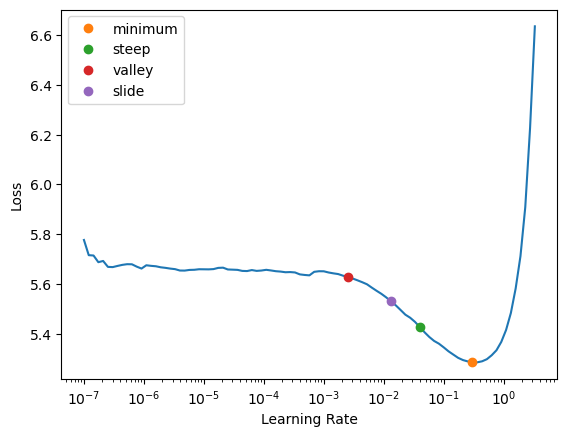

In [26]:
lr = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [27]:
learn.fine_tune(3, lr.slide)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.753478,4.103902,0.264466,60.576218,00:05


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.181787,3.973020,0.283772,53.144764,00:06
1,4.067071,3.922883,0.290176,50.545937,00:06
2,3.938557,3.912054,0.292643,50.001541,00:06


We save the encoder part of the model, which we'll use in the next step.

In [28]:
learn.save_encoder('emotions_finetuned_lm_encoder')

### Test the language model

It's fun to test the language model by having it guess the next given number of words on a starting text:

In [29]:
from pprint import pprint as pp

In [30]:
def make_text(seed_text, nb_words):
    """
    Use the trained language model to produce text. 
    Input:
        seed_text: some text to get the model started
        nb_words: number of words to produce
    """
    pred = learn.predict(seed_text, nb_words, temperature=0.75)
    pp(pred)

In [31]:
make_text("I'm not feeling too good as my", 40)

('I xxunk not feeling too good as my life is a little bit more irritable i '
 'feel so numb i m feeling a little bit irritated i feel really sorry for '
 'myself i get back into the car looking at a car i feel')


This seems to produce text that resembles the input text, but it's not very coherent. This is because the model is not designed to generate text, but to predict the next word in a sequence of words.

However, this is not the task we're interested in. 

## Step 2: Train the classifier

In [40]:
db = DataBlock(blocks=(TextBlock.from_df(text_cols='text', vocab=data_lm.vocab), CategoryBlock), 
                  get_x = ColReader(cols='text'), 
                  get_y = ColReader(cols='named_label'),
                  splitter = ColSplitter(col='is_test'))

dls = db.dataloaders(df, bs=16)

In [41]:
dls.show_batch()

,text,category
0,xxbos i feel in my bones like nobody cares if i m here nobody cares if i m gone here i am again saying i m feeling so lonely people either say its ok to be alone or just go home it xxunk me and i do nt know why it does nt mean i do nt try i try and try but people just treat me like i m a xxunk,sadness
1,xxbos i might go out of existance i smile pick up my pen and fill the page with the things that you say the thoughts you obtain the moments you xxunk far away its cause you re going insane and suddenly i m left afraid because i m not feeling that way instead i m amazed why you got ta be that way,surprise
2,xxbos i m feeling a little bit more positive now as things were quite hard at first as my xxunk were eaten up quickly with xxunk and i did nt want to become a burden to my boyfriend but we ve come out the other end and i m feeling brighter and more inspired about things to come,joy
3,xxbos i m not too xxunk about any of those stops but that s kind of a good thing because i wo nt feel pressured to go see and do everything there is to do and i can just hopefully relax and focus on making it fun for the kids which by xxunk makes it fun for me,fear
4,xxbos i think for myself i feel everyone is greedy but in their own little ways whether that is going for the good or bad way that s another issue because usually you link both together but right now i m trying to separate both issue separately so we can see the sole topic more xxunk,anger
5,xxbos i still love my so and wish the best for him i can no longer tolerate the effect that xxunk has on our lives and the fact that is has turned my so into a bitter angry person who is not always particularly kind to the people around him when he is feeling stressed,sadness
6,xxbos i feel stupid and xxunk here we are now xxunk us a xxunk an xxunk a xxunk my xxunk yeah hey yay i m worse at what i do best and for this gift i feel blessed our little group has always been and always will until the end xxwrep 3 hello how low,sadness
7,xxbos i can achieve on my own it makes me embrace the pain of extreme effort and physical xxunk it xxunk to myself that i can succeed at things that i can be healthy and fit and have a body that i love and feel comfortable in and it just makes me feel special,joy
8,xxbos i ve been a huge fan of twitter since i joined in and as my xxunk with those that i follow has increased over time i ve found myself feeling like this is a go to source for me for any number of content options news xxunk xxunk marketing you get the picture,joy


In [45]:
learn_clf = text_classifier_learner(dls, AWD_LSTM, pretrained=True, 
                                    metrics=[accuracy, 
                                             F1Score(average='weighted')
                                             ], 
                                    model_dir='.').to_fp16()

In [46]:
learn_clf = learn_clf.load_encoder('emotions_finetuned_lm_encoder')

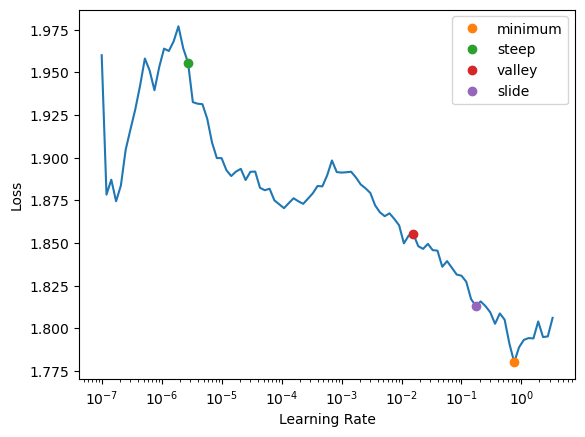

In [47]:
lr = learn_clf.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [48]:
learn_clf.fine_tune(6, base_lr=lr.valley)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.419794,1.336713,0.500000,0.419555,00:08


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.561451,0.322998,0.890500,0.888780,00:14
1,0.302498,0.178587,0.924500,0.925532,00:14
2,0.253326,0.138707,0.921500,0.921280,00:15
3,0.193587,0.119233,0.935000,0.934992,00:15
4,0.170957,0.122935,0.932500,0.932520,00:14
5,0.143060,0.126579,0.931000,0.930693,00:14


In [49]:
learn_clf.show_results()

,text,category,category_
0,xxbos i feel i am appreciative i take care of the baby i try to keep the apt clean as much as possible and i try not to call him a million times to find out when hell be home it xxunk from day to day as he is sort of self xxunk so its hard to plan things around his schedule,joy,joy
1,xxbos i feel like i know who most of them are by now and am starting to develop my likes and xxunk though i have not been keen on the snap xxunk they have seemed pretty pointless the first one to go returned and the two xxunk made absolutely zero impact on me so they won t be missed,joy,joy
2,xxbos i started feeling a little funny but this was not anxiety but at the time i did nt know so i started to tell my brother man i do nt feel good and he said what s wrong i said i do nt know but u better drive so i pulled over and let him drive,surprise,surprise
3,xxbos i get scared i feel ignored i feel happy i get silly i choke on my own words i make wishes i have dreams and i still want to believe anything could happen in this world for an ordinary girl like you like me for an ordinary girl like you like me how are you,sadness,sadness
4,xxbos i am feeling a little more relaxed i am certainly not feeling refreshed thanks to drunk xxunk who decided letting off xxunk every half an hour all night would be super fun and the fact that it s impossible to sleep in the freezing cold with a complaining toddler but i have certainly xxunk,joy,joy
5,xxbos i would say no not yet and i would feel superior and in fact self xxunk even if i would not admit it back then because i remember looking at the point so i can see that the point did come up but i could did not face it to protect my ego,joy,joy
6,xxbos i actually was in a meeting last week where someone yelled at an older lady because her phone rang i felt terrible for her your boss treats you xxunk or in this case someone makes you feel you are not worth anything is only allowing those who offended to steal your joy,anger,anger
7,xxbos i haven t been able to do a lot of stuff most people managed to do in various points of their lives i feel that i have missed out a lot in life and i know that my current path is my only ticket to live a live that i want to,sadness,sadness
8,xxbos i come in contact on a regular basis and the sooner i can figure out how to be kind to them in all situations the sooner they will feel valued appreciated loved and the desire to learn how to pass that kindness on to others as i am learning to do,joy,joy


In [50]:
interp = ClassificationInterpretation.from_learner(learn_clf)

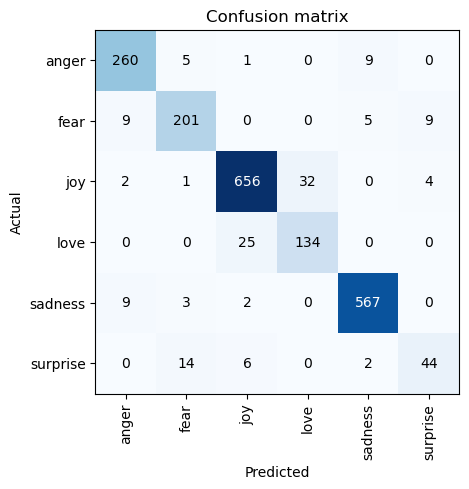

In [51]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=5)

[('joy', 'love', 32),
 ('love', 'joy', 25),
 ('surprise', 'fear', 14),
 ('anger', 'sadness', 9),
 ('fear', 'anger', 9),
 ('fear', 'surprise', 9),
 ('sadness', 'anger', 9),
 ('surprise', 'joy', 6),
 ('anger', 'fear', 5),
 ('fear', 'sadness', 5)]

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

       anger       0.93      0.95      0.94       275
        fear       0.90      0.90      0.90       224
         joy       0.95      0.94      0.95       695
        love       0.81      0.84      0.82       159
     sadness       0.97      0.98      0.97       581
    surprise       0.77      0.67      0.72        66

    accuracy                           0.93      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.93      0.93      0.93      2000



In [54]:
interp.plot_top_losses(5)

,input,target,predicted,probability,loss
0,xxbos i ve been feeling from my adoring fans that would be xxunk whole like of you who are my friends here i felt brave and excited and xxunk forth with guitar in hand to a local open xxunk night,love,joy,0.9918103814125061,5.314470291137695
1,xxbos i feel like i am in xxunk kissing those sweet lips make me feel like i xxunk into a magical world of love,joy,love,0.9732023477554321,5.283614158630371
2,xxbos whenever i put myself in others shoes and try to make the person happy,anger,joy,0.9329832196235657,3.8125321865081787
3,xxbos i feel unprotected a class post count link href http xxunk in process,sadness,fear,0.9941408038139343,3.65704607963562
4,xxbos when we xxunk xxunk in our flat and got stuck in a chair,anger,fear,0.9636459946632385,3.6366405487060547


# Using Transformers

Now, let's construct a classifier based on a Transformers model. We'll use Tranformer library from Hugging Face and the DistilBERT model.

In [6]:
import torch

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

num_labels = 6
model_ckpt = "distilbert-base-uncased"


model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(torch.device("cuda")))

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [9]:
emotion_tokenized = emotion.map(tokenize, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [11]:
from transformers import Trainer, TrainingArguments

batch_size = 64

training_args = TrainingArguments(output_dir=".",
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  log_level="error")
     

In [12]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotion_tokenized["train"],
                  eval_dataset=emotion_tokenized["validation"],
                  tokenizer=tokenizer)

trainer.train()

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.2639501392841339, 'eval_accuracy': 0.916, 'eval_f1': 0.9159859910905804, 'eval_runtime': 0.9856, 'eval_samples_per_second': 2029.279, 'eval_steps_per_second': 32.468, 'epoch': 1.0}
{'loss': 0.5046, 'grad_norm': 8.523388862609863, 'learning_rate': 1.2e-05, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.1599658578634262, 'eval_accuracy': 0.9375, 'eval_f1': 0.9379420956843323, 'eval_runtime': 0.9729, 'eval_samples_per_second': 2055.74, 'eval_steps_per_second': 32.892, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.15256832540035248, 'eval_accuracy': 0.932, 'eval_f1': 0.9328271003259544, 'eval_runtime': 0.9753, 'eval_samples_per_second': 2050.754, 'eval_steps_per_second': 32.812, 'epoch': 3.0}
{'loss': 0.1178, 'grad_norm': 3.6431221961975098, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.1455267071723938, 'eval_accuracy': 0.937, 'eval_f1': 0.9370819675304846, 'eval_runtime': 0.9661, 'eval_samples_per_second': 2070.206, 'eval_steps_per_second': 33.123, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.14503353834152222, 'eval_accuracy': 0.9375, 'eval_f1': 0.9376384841152394, 'eval_runtime': 0.9878, 'eval_samples_per_second': 2024.694, 'eval_steps_per_second': 32.395, 'epoch': 5.0}
{'train_runtime': 146.2285, 'train_samples_per_second': 547.089, 'train_steps_per_second': 8.548, 'train_loss': 0.26652463989257813, 'epoch': 5.0}


TrainOutput(global_step=1250, training_loss=0.26652463989257813, metrics={'train_runtime': 146.2285, 'train_samples_per_second': 547.089, 'train_steps_per_second': 8.548, 'train_loss': 0.26652463989257813, 'epoch': 5.0})

In [15]:
test_preds = trainer.predict(emotion_tokenized["test"])

  0%|          | 0/32 [00:00<?, ?it/s]

In [16]:
test_preds.metrics

{'test_loss': 0.15953868627548218,
 'test_accuracy': 0.928,
 'test_f1': 0.9279589564408679,
 'test_runtime': 0.9265,
 'test_samples_per_second': 2158.675,
 'test_steps_per_second': 34.539}

> Alternative: Using LMs as feature extractors and training models on top of them